<a href="https://colab.research.google.com/github/nikiduki/ts_ml/blob/master/trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install catboost
!pip install optuna
import optuna
import xgboost
import catboost
import lightgbm as lgb
import numpy as np
import yfinance as yf
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split

SIZE = 10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


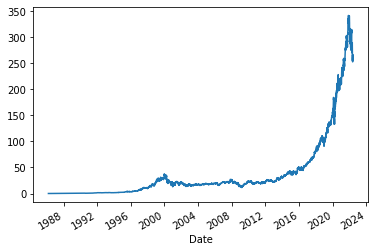

In [ ]:
tickerSymbol = 'MSFT'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='max')

tickerDf.Close.plot()

In [ ]:
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055654,0.063838,0.055654,0.061109,1031788800,0.0,0.0
1986-03-14,0.061109,0.064384,0.061109,0.063292,308160000,0.0,0.0
1986-03-17,0.063292,0.064929,0.063292,0.064384,133171200,0.0,0.0
1986-03-18,0.064384,0.064929,0.062201,0.062746,67766400,0.0,0.0
1986-03-19,0.062746,0.063292,0.061109,0.061655,47894400,0.0,0.0


In [ ]:
tickerDf = tickerDf.drop("Volume", axis=1)
tickerDf = tickerDf.drop("Dividends", axis=1)
tickerDf = tickerDf.drop("Stock Splits", axis=1)
tickerDf.head()

,Open,High,Low,Close
Date,,,,
1986-03-13,0.055654,0.063838,0.055654,0.061109
1986-03-14,0.061109,0.064384,0.061109,0.063292
1986-03-17,0.063292,0.064929,0.063292,0.064384
1986-03-18,0.064384,0.064929,0.062201,0.062746
1986-03-19,0.062746,0.063292,0.061109,0.061655


In [ ]:
def get_columns(data, columns_data, col_shift):
  for i in range(1, SIZE+1):
    col_name = f'shift_{col_shift}_{i}'
    data[col_name] = data[col_shift].shift(i)
    columns_data.append(col_name)
  data = data.dropna()
  return data

In [ ]:
def get_features(data, col_pred):
  columns_data = [col_pred + '_pct_change']
  for column in data.columns[:4]:
    data[f'{column}_pct_change'] = data[column].pct_change()
    col_shift = f'{column}_pct_change'
    data = get_columns(data, columns_data, col_shift)
    display(data)
    if column!=col_pred:
      data = data.drop(column, axis=1)
      data = data.drop(f'{column}_pct_change', axis=1)
  return data, columns_data

In [ ]:
def un_pct_change(diff, orig):
  un_pct_change = (orig.shift(1) * diff.ravel()) + orig.shift(1)
  return un_pct_change[1:]

In [ ]:
def metrics(pred, target):
  return mean_squared_error(pred, target), mean_absolute_error(pred, target), mean_absolute_percentage_error(pred, target)

In [ ]:
def trading(preds_high, preds_low, target_high, target_low, target_close, L = 1):
  profit = 0
  pos = False
  num_steps = len(target_close)
  success_deals = 0
  failed_deals = 0
  deals = []
  commission = 0
  for step in range(num_steps):
    buy_price = preds_low[step] / L
    sell_price = preds_high[step] * L
    if buy_price >= target_low[step]:
      pos = True
      profit -= commission / 100 * buy_price
    if pos:
      if sell_price <= target_high[step]:
        p = sell_price - buy_price
        success_deals += 1
        status = 'success'
      else:
        sell_price = target_close[step]
        p = sell_price - buy_price
        failed_deals += 1
        status = 'failed'
      profit += p
      pos = False
      deals.append({
        'status' : status,
        'buy_price' : buy_price,
        'sell_price' : sell_price,
        'profit' : p,
        'total_profit' : profit,
        'success_deals' : success_deals,
        'failed_deals' : failed_deals
      })
  return deals

In [ ]:
def objectives_ridge(trial):
  alpha = trial.suggest_uniform('alpha', 0.0, 2.0)
  model = Ridge(alpha=alpha)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [ ]:
def objectives_lasso(trial):
  alpha = trial.suggest_uniform('alpha', 0.0, 2.0)
  model = Lasso(alpha=alpha)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [ ]:
def objectives_cb(trial):
  params_cb = {
                "subsample": trial.suggest_float("subsample", 0.5, 0.99),
                'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.99),
                "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0),
                "max_depth": trial.suggest_int("max_depth", 4, 10, step=1),
                "n_estimators": trial.suggest_int("n_estimators", 100, 2500, step=1),
                'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                'random_state': 0,
                'loss_function': 'MAE', 
                'eval_metric': 'MAE', 
                'one_hot_max_size': 0,
                'boost_from_average': True
              }
  model = catboost.CatBoostRegressor(**params_cb)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [ ]:
def objectives_lgb(trial):
  params_lgb = {
            'num_leaves': trial.suggest_int('num_leaves', 200, 3000),
            'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
            'max_bin': trial.suggest_int('max_bin', 2, 100),
            'learning_rate': trial.suggest_uniform('learning_rate',0, 1),
                  }
  model = lgb.LGBMRegressor(**params_lgb)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE         

In [ ]:
def objectives_rf(trial):
  params_rf = {
          'max_depth' : trial.suggest_int('max_depth', 1, 500),
          'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']),
          'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 1, 1000),
          'n_estimators' :  trial.suggest_int('n_estimators', 30, 1000)
            }

  model = RandomForestRegressor(**params_rf)
  model.fit(X_train, y_train.ravel())
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE         

In [ ]:
def objectives_dtr(trial):
  params_dtr = {
            "splitter": trial.suggest_categorical("splitter", ["best","random"]),
            "max_depth" : trial.suggest_int("max_depth", 1, 12),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
            "min_weight_fraction_leaf" : trial.suggest_uniform("min_weight_fraction_leaf", 0.05, 0.5),
            "max_features" : trial.suggest_categorical("max_features", ["auto","log2","sqrt",None]),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes", 10, 90, 10)
            }
  model = DecisionTreeRegressor(**params_dtr)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [ ]:
optuna_objectives = {
                     'LinearRegression_ridge' : objectives_ridge,
                     'LinearRegression_lasso' : objectives_lasso,
                     'CatBoostRegressor' : objectives_cb,
                     'DecisionTreeRegressor' : objectives_dtr,
                     'LGBMRegressor' : objectives_lgb,
                     'RandomForestRegressor' : objectives_rf
                     }

params_models = {
                    'LinearRegression' : {},
                    'LinearRegression_ridge' : {'alpha': 0.719015801147572},
                    'LinearRegression_lasso' : {'alpha': 1.0976270078546495},
                    'CatBoostRegressor' : {'subsample': 0.8576953755877884, 'od_wait': 17, 'colsample_bylevel': 0.7553079370400233, 'random_strength': 1, 'l2_leaf_reg': 10.799829719923604, 'max_depth': 4, 'n_estimators': 2005, 'learning_rate': 0.0097791867608511},
                    'DecisionTreeRegressor' : {'splitter': 'best', 'max_depth': 8, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.05929294975957791, 'max_features': 'auto', 'max_leaf_nodes': 80},
                    'LGBMRegressor' : {'num_leaves': 1842, 'n_estimators': 158, 'max_bin': 84, 'learning_rate': 0.004695476192547066},
                    'RandomForestRegressor' : {'max_depth': 481, 'max_features': 'auto', 'max_leaf_nodes': 17, 'n_estimators': 932}
                    }                    
models = {
          'LinearRegression' : LinearRegression,
          'LinearRegression_ridge' : Ridge, 
          'LinearRegression_lasso' : Lasso, 
          'DecisionTreeRegressor' : DecisionTreeRegressor, 
          'RandomForestRegressor' : RandomForestRegressor, 
          'LGBMRegressor' : lgb.LGBMRegressor,
          'CatBoostRegressor' : catboost.CatBoostRegressor
          }

In [ ]:
def pipeline(model, data, col_pred, train=False):
  data, columns_data = get_features(data, col_pred)
  display(data)
  X = data[columns_data[1:]].values
  y = data[columns_data[0]].values.reshape(-1, 1)
  global X_train, y_train, X_test, y_test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False, random_state = 42)

  # optuna
  # opt = optuna.create_study(direction='minimize',sampler=optuna.samplers.RandomSampler(seed=0))
  # opt.optimize(optuna_objectives[model], n_trials=50)
  # trial = opt.best_trial
  # params_best = dict(trial.params.items())     
  # model = models[model](**params_best) 
  model = models[model](**params_models[model])

  model.fit(X_train, y_train)
  if train:
    pred = model.predict(X_train)
  else:
    pred = model.predict(X_test)
  un_pct_change_pred = un_pct_change(pred, data[col_pred][len(data) - len(pred):])
  if train:
    un_pct_change_y_train = un_pct_change(y_train, data[col_pred][len(data) - len(pred):])
    print(f'\npct_change_metrics (MSE, MAE, MAPE) = {metrics(pred, y_train)}')
    print(f'\nun_pct_change_metrics (MSE, MAE, MAPE) = {metrics(un_pct_change_pred, un_pct_change_y_train)}')
  else:
    un_pct_change_y_test = un_pct_change(y_test, data[col_pred][len(data) - len(pred):])
    print(f'\npct_change_metrics (MSE, MAE, MAPE) = {metrics(pred, y_test)}')
    print(f'\nun_pct_change_metrics (MSE, MAE, MAPE) = {metrics(un_pct_change_pred, un_pct_change_y_test)}')

  # return pred, y_test
  if train:
    return un_pct_change_pred, un_pct_change_y_train
  return un_pct_change_pred, un_pct_change_y_test

In [ ]:
cols = ('High', 'Low')
preds_targets = pd.DataFrame()
for name_model in models.keys():
  for col in cols:
      print(f'\n---------------------------{name_model}---------------------------\n')
      preds_targets[f'pred of {col} with {name_model}'], preds_targets[f'target of {col} with {name_model}'] = pipeline(name_model, tickerDf, col)


---------------------------LinearRegression---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.072567,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.070385,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.070385,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.069294,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.070385,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,High,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.0001518336897354109, 0.008260734749759024, 732.0036266152027)

un_pct_change_metrics (MSE, MAE, MAPE) = (2.5668645081347945, 0.7995936551181145, 0.008253189591074827)

---------------------------LinearRegression---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.000169734511393301, 0.008669358042087573, 7.682674339791251)

un_pct_change_metrics (MSE, MAE, MAPE) = (3.088599111437215, 0.860691689198871, 0.008658374067259349)

---------------------------LinearRegression_ridge---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.072567,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.070385,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.070385,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.069294,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.070385,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,High,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.00015899365346357978, 0.008522615881436183, 9.536183701497833)

un_pct_change_metrics (MSE, MAE, MAPE) = (2.664513105619318, 0.8196511322622524, 0.008512337032284864)

---------------------------LinearRegression_ridge---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.00017478767548899035, 0.009014076968147697, 47.34448662203825)

un_pct_change_metrics (MSE, MAE, MAPE) = (3.2708062642104214, 0.8988370011232945, 0.009005152905112355)

---------------------------LinearRegression_lasso---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.072567,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.070385,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.070385,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.069294,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.070385,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,High,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.00017690850063623132, 0.009140987227124813, 8.18954970805302)

un_pct_change_metrics (MSE, MAE, MAPE) = (3.005994639883197, 0.8773618768446747, 0.0091284032227034)

---------------------------LinearRegression_lasso---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.00020014782423373364, 0.009789329729015474, 8.476308649090454)

un_pct_change_metrics (MSE, MAE, MAPE) = (3.749953661122396, 0.9546099888722468, 0.009777719791137618)

---------------------------DecisionTreeRegressor---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.072567,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.070385,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.070385,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.069294,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.070385,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,High,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.0001668884283527967, 0.008972777941360742, 2.9964542499063365)

un_pct_change_metrics (MSE, MAE, MAPE) = (2.914003254485204, 0.871516969862066, 0.008959448595636774)

---------------------------DecisionTreeRegressor---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.00018715499851329104, 0.009609094045646324, 7.650395055037539)

un_pct_change_metrics (MSE, MAE, MAPE) = (3.5914975343168067, 0.9582918950903632, 0.009607422166991822)

---------------------------RandomForestRegressor---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.072567,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.070385,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.070385,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.069294,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.070385,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,High,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



pct_change_metrics (MSE, MAE, MAPE) = (0.00016249347245047104, 0.008804046361474319, 7.074657029275858)

un_pct_change_metrics (MSE, MAE, MAPE) = (2.756850557934351, 0.8460676875814616, 0.008790973847404165)

---------------------------RandomForestRegressor---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



pct_change_metrics (MSE, MAE, MAPE) = (0.00018256161013859934, 0.009409667489598176, 7.428131280025546)

un_pct_change_metrics (MSE, MAE, MAPE) = (3.4170658613319618, 0.934155412185771, 0.009409473193624025)

---------------------------LGBMRegressor---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.072567,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.070385,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.070385,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.069294,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.070385,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,High,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



pct_change_metrics (MSE, MAE, MAPE) = (0.0001572049258191888, 0.008508780205691398, 10.890581140624967)

un_pct_change_metrics (MSE, MAE, MAPE) = (2.6242456400525676, 0.8166840157618195, 0.008498384443780914)

---------------------------LGBMRegressor---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



pct_change_metrics (MSE, MAE, MAPE) = (0.00017486493596715718, 0.009077875191198443, 25.504230256276877)

un_pct_change_metrics (MSE, MAE, MAPE) = (3.260010714208925, 0.9006216543591538, 0.009068949671824797)

---------------------------CatBoostRegressor---------------------------



,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.072567,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.070385,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.070385,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.069294,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.070385,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,High,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.070931,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.072022,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.070385,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.069294,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.069294,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,261.500000,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,261.329987,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


0:	learn: 0.0200487	total: 6.08ms	remaining: 12.2s
1:	learn: 0.0200176	total: 12.6ms	remaining: 12.6s
2:	learn: 0.0199852	total: 17.7ms	remaining: 11.8s
3:	learn: 0.0199513	total: 22.6ms	remaining: 11.3s
4:	learn: 0.0199171	total: 27.3ms	remaining: 10.9s
5:	learn: 0.0198881	total: 32.3ms	remaining: 10.8s
6:	learn: 0.0198543	total: 39.3ms	remaining: 11.2s
7:	learn: 0.0198213	total: 44.2ms	remaining: 11s
8:	learn: 0.0197944	total: 48.8ms	remaining: 10.8s
9:	learn: 0.0197640	total: 53.5ms	remaining: 10.7s
10:	learn: 0.0197317	total: 58.5ms	remaining: 10.6s
11:	learn: 0.0197021	total: 63.2ms	remaining: 10.5s
12:	learn: 0.0196737	total: 68ms	remaining: 10.4s
13:	learn: 0.0196499	total: 72.7ms	remaining: 10.3s
14:	learn: 0.0196209	total: 77.8ms	remaining: 10.3s
15:	learn: 0.0195919	total: 82.9ms	remaining: 10.3s
16:	learn: 0.0195646	total: 87.8ms	remaining: 10.3s
17:	learn: 0.0195336	total: 92.7ms	remaining: 10.2s
18:	learn: 0.0195053	total: 97.3ms	remaining: 10.2s
19:	learn: 0.0194801	total

,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.069839,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.068748,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068203,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,253.429993,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,253.500000,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


0:	learn: 0.0219562	total: 7.96ms	remaining: 16s
1:	learn: 0.0219232	total: 13.8ms	remaining: 13.8s
2:	learn: 0.0218789	total: 18.9ms	remaining: 12.6s
3:	learn: 0.0218370	total: 23.5ms	remaining: 11.8s
4:	learn: 0.0217951	total: 28.2ms	remaining: 11.3s
5:	learn: 0.0217589	total: 33.3ms	remaining: 11.1s
6:	learn: 0.0217182	total: 37.9ms	remaining: 10.8s
7:	learn: 0.0216775	total: 43ms	remaining: 10.7s
8:	learn: 0.0216405	total: 47.8ms	remaining: 10.6s
9:	learn: 0.0216053	total: 52.6ms	remaining: 10.5s
10:	learn: 0.0215649	total: 57.6ms	remaining: 10.4s
11:	learn: 0.0215300	total: 62.4ms	remaining: 10.4s
12:	learn: 0.0214936	total: 67.2ms	remaining: 10.3s
13:	learn: 0.0214610	total: 72.2ms	remaining: 10.3s
14:	learn: 0.0214255	total: 77ms	remaining: 10.2s
15:	learn: 0.0213921	total: 81.9ms	remaining: 10.2s
16:	learn: 0.0213599	total: 86.5ms	remaining: 10.1s
17:	learn: 0.0213286	total: 91.3ms	remaining: 10.1s
18:	learn: 0.0212934	total: 96.2ms	remaining: 10.1s
19:	learn: 0.0212640	total: 

In [ ]:
preds_targets.head()

NameError: ignored

In [ ]:
tmp = pd.DataFrame()
tmp['High_target'] = tickerDf['High'][len(tickerDf) - len(preds_targets['pred of High with LinearRegression_ridge']):]
tmp['Ridge'] = preds_targets['pred of High with LinearRegression_ridge']
tmp['Lasso'] = preds_targets['pred of High with LinearRegression_lasso']
tmp['DecisionTree'] = preds_targets['pred of High with DecisionTreeRegressor']
tmp['RandomForest'] = preds_targets['pred of High with RandomForestRegressor']
tmp['LightGBM'] = preds_targets['pred of High with LGBMRegressor']
tmp['CatBoost'] = preds_targets['pred of High with CatBoostRegressor']
tmp.head()

,High_target,Ridge,Lasso,DecisionTree,RandomForest,LightGBM,CatBoost
Date,,,,,,,
2010-07-02,18.222159,18.190900,18.118190,18.279495,18.218408,18.324119,18.268949
2010-07-06,18.695566,18.262118,18.242498,18.319618,18.289584,18.314446,18.320914
2010-07-07,18.874061,18.815118,18.716434,18.883065,18.896811,18.863402,18.906621
2010-07-08,19.106890,18.982699,18.895128,19.063350,19.036136,19.077499,19.038504
2010-07-09,18.943904,19.075691,19.128217,19.006134,19.109570,19.073332,19.132563


In [ ]:
MSE_High_ridge = mean_squared_error(tmp['High_target'], tmp['Ridge'])
MSE_High_lasso = mean_squared_error(tmp['High_target'], tmp['Lasso'])
MSE_High_dtr = mean_squared_error(tmp['High_target'], tmp['DecisionTree'])
MSE_High_rf = mean_squared_error(tmp['High_target'], tmp['RandomForest'])
MSE_High_lgb = mean_squared_error(tmp['High_target'], tmp['LightGBM'])
MSE_High_cb = mean_squared_error(tmp['High_target'], tmp['CatBoost'])
MAE_High_ridge = mean_absolute_error(tmp['High_target'], tmp['Ridge'])
MAE_High_lasso = mean_absolute_error(tmp['High_target'], tmp['Lasso'])
MAE_High_dtr = mean_absolute_error(tmp['High_target'], tmp['DecisionTree'])
MAE_High_rf = mean_absolute_error(tmp['High_target'], tmp['RandomForest'])
MAE_High_lgb = mean_absolute_error(tmp['High_target'], tmp['LightGBM'])
MAE_High_cb = mean_absolute_error(tmp['High_target'], tmp['CatBoost'])
MAPE_High_ridge = mean_absolute_percentage_error(tmp['High_target'], tmp['Ridge'])
MAPE_High_lasso = mean_absolute_percentage_error(tmp['High_target'], tmp['Lasso'])
MAPE_High_dtr = mean_absolute_percentage_error(tmp['High_target'], tmp['DecisionTree'])
MAPE_High_rf = mean_absolute_percentage_error(tmp['High_target'], tmp['RandomForest'])
MAPE_High_lgb = mean_absolute_percentage_error(tmp['High_target'], tmp['LightGBM'])
MAPE_High_cb = mean_absolute_percentage_error(tmp['High_target'], tmp['CatBoost'])
print("Metrics of High:\n",
      f"\n---------MSE---------\n\nRidge: {MSE_High_ridge}\nLasso: {MSE_High_lasso}\nDecisionTree: {MSE_High_dtr}\nRandomForest: {MSE_High_rf}\nLightGBM: {MSE_High_lgb}\nCatBoost: {MSE_High_cb}\n",
      f"\n---------MAE---------\n\nRidge: {MAE_High_ridge}\nLasso: {MAE_High_lasso}\nDecisionTree: {MAE_High_dtr}\nRandomForest: {MAE_High_rf}\nLightGBM: {MAE_High_lgb}\nCatBoost: {MAE_High_cb}\n",
      f"\n---------MAPE---------\n\nRidge: {MAPE_High_ridge}\nLasso: {MAPE_High_lasso}\nDecisionTree: {MAPE_High_dtr}\nRandomForest: {MAPE_High_rf}\nLightGBM: {MAPE_High_lgb}\nCatBoost: {MAPE_High_cb}")

Metrics of High:
 
---------MSE---------

Ridge: 2.664513105619317
Lasso: 3.005994639883196
DecisionTree: 2.9140032544852033
RandomForest: 2.75685055793435
LightGBM: 2.624245640052566
CatBoost: 2.6348471159742175
 
---------MAE---------

Ridge: 0.8196511322622524
Lasso: 0.8773618768446749
DecisionTree: 0.8715169698620658
RandomForest: 0.8460676875814614
LightGBM: 0.8166840157618195
CatBoost: 0.8244721167881534
 
---------MAPE---------

Ridge: 0.008500666174697821
Lasso: 0.009127926872811028
DecisionTree: 0.008953289010932109
RandomForest: 0.008785785917018443
LightGBM: 0.008489681899282366
CatBoost: 0.00852387137811931


In [ ]:
tmp = pd.DataFrame()
tmp['Low_target'] = tickerDf['Low'][len(tickerDf) - len(preds_targets['pred of Low with LinearRegression_ridge']):]
tmp['Ridge'] = preds_targets['pred of Low with LinearRegression_ridge']
tmp['Lasso'] = preds_targets['pred of Low with LinearRegression_lasso']
tmp['DecisionTree'] = preds_targets['pred of Low with DecisionTreeRegressor']
tmp['RandomForest'] = preds_targets['pred of Low with RandomForestRegressor']
tmp['LightGBM'] = preds_targets['pred of Low with LGBMRegressor']
tmp['CatBoost'] = preds_targets['pred of Low with CatBoostRegressor']
tmp.head(10)

,Low_target,Ridge,Lasso,DecisionTree,RandomForest,LightGBM,CatBoost
Date,,,,,,,
2010-07-02,17.888448,17.717095,17.660479,17.759439,17.666314,17.707824,17.703140
2010-07-06,18.299770,17.906487,17.909108,17.784014,17.856347,17.899587,17.849022
2010-07-07,18.323051,18.440067,18.320904,18.441758,18.497909,18.436055,18.492514
2010-07-08,18.602442,18.491591,18.344213,18.617368,18.549225,18.537578,18.551466
2010-07-09,18.742125,18.583010,18.623926,18.493840,18.568072,18.531099,18.540396
2010-07-12,18.951670,18.657711,18.763771,18.738358,18.671361,18.707759,18.612933
2010-07-13,19.324187,19.135797,18.973557,19.098717,19.158886,19.057945,19.134731
2010-07-14,19.494922,19.375362,19.346505,19.382553,19.381948,19.268339,19.361788
2010-07-15,19.386274,19.555393,19.517437,19.553804,19.568702,19.563081,19.610115


In [ ]:
MSE_High_ridge = mean_squared_error(tmp['Low_target'], tmp['Ridge'])
MSE_High_lasso = mean_squared_error(tmp['Low_target'], tmp['Lasso'])
MSE_High_dtr = mean_squared_error(tmp['Low_target'], tmp['DecisionTree'])
MSE_High_rf = mean_squared_error(tmp['Low_target'], tmp['RandomForest'])
MSE_High_lgb = mean_squared_error(tmp['Low_target'], tmp['LightGBM'])
MSE_High_cb = mean_squared_error(tmp['Low_target'], tmp['CatBoost'])
MAE_High_ridge = mean_absolute_error(tmp['Low_target'], tmp['Ridge'])
MAE_High_lasso = mean_absolute_error(tmp['Low_target'], tmp['Lasso'])
MAE_High_dtr = mean_absolute_error(tmp['Low_target'], tmp['DecisionTree'])
MAE_High_rf = mean_absolute_error(tmp['Low_target'], tmp['RandomForest'])
MAE_High_lgb = mean_absolute_error(tmp['Low_target'], tmp['LightGBM'])
MAE_High_cb = mean_absolute_error(tmp['Low_target'], tmp['CatBoost'])
MAPE_High_ridge = mean_absolute_percentage_error(tmp['Low_target'], tmp['Ridge'])
MAPE_High_lasso = mean_absolute_percentage_error(tmp['Low_target'], tmp['Lasso'])
MAPE_High_dtr = mean_absolute_percentage_error(tmp['Low_target'], tmp['DecisionTree'])
MAPE_High_rf = mean_absolute_percentage_error(tmp['Low_target'], tmp['RandomForest'])
MAPE_High_lgb = mean_absolute_percentage_error(tmp['Low_target'], tmp['LightGBM'])
MAPE_High_cb = mean_absolute_percentage_error(tmp['Low_target'], tmp['CatBoost'])
print("Metrics of Low:\n",
      f"\n---------MSE---------\n\nRidge: {MSE_High_ridge}\nLasso: {MSE_High_lasso}\nDecisionTree: {MSE_High_dtr}\nRandomForest: {MSE_High_rf}\nLightGBM: {MSE_High_lgb}\nCatBoost: {MSE_High_cb}\n",
      f"\n---------MAE---------\n\nRidge: {MAE_High_ridge}\nLasso: {MAE_High_lasso}\nDecisionTree: {MAE_High_dtr}\nRandomForest: {MAE_High_rf}\nLightGBM: {MAE_High_lgb}\nCatBoost: {MAE_High_cb}\n",
      f"\n---------MAPE---------\n\nRidge: {MAPE_High_ridge}\nLasso: {MAPE_High_lasso}\nDecisionTree: {MAPE_High_dtr}\nRandomForest: {MAPE_High_rf}\nLightGBM: {MAPE_High_lgb}\nCatBoost: {MAPE_High_cb}")

Metrics of Low:
 
---------MSE---------

Ridge: 3.270806264210422
Lasso: 3.7499536611223956
DecisionTree: 3.5914975343168076
RandomForest: 3.4170658613319618
LightGBM: 3.2600107142089256
CatBoost: 3.2943616222903964
 
---------MAE---------

Ridge: 0.8988370011232947
Lasso: 0.9546099888722468
DecisionTree: 0.9582918950903632
RandomForest: 0.9341554121857711
LightGBM: 0.900621654359154
CatBoost: 0.905903492779945
 
---------MAPE---------

Ridge: 0.009031501961822277
Lasso: 0.009799737713156205
DecisionTree: 0.009615834094994346
RandomForest: 0.009417777473133765
LightGBM: 0.009091601823675818
CatBoost: 0.009089945851497638


In [ ]:
dtr_df = pd.DataFrame(trading(preds_targets['pred of High with DecisionTreeRegressor'], preds_targets['pred of Low with DecisionTreeRegressor'], preds_targets['target of High with DecisionTreeRegressor'], preds_targets['target of Low with DecisionTreeRegressor'], tickerDf['Close'][len(tickerDf['Close'])-len(preds_targets['pred of High with DecisionTreeRegressor']):]))
rf_df = pd.DataFrame(trading(preds_targets['pred of High with RandomForestRegressor'], preds_targets['pred of Low with RandomForestRegressor'], preds_targets['target of High with RandomForestRegressor'], preds_targets['target of Low with RandomForestRegressor'], tickerDf['Close'][len(tickerDf['Close'])-len(preds_targets['pred of High with RandomForestRegressor']):]))
reg_l_df = pd.DataFrame(trading(preds_targets['pred of High with LinearRegression_lasso'], preds_targets['pred of Low with LinearRegression_lasso'], preds_targets['target of High with LinearRegression_lasso'], preds_targets['target of Low with LinearRegression_lasso'], tickerDf['Close'][len(tickerDf['Close'])-len(preds_targets['pred of High with LinearRegression_lasso']):]))
reg_r_df = pd.DataFrame(trading(preds_targets['pred of High with LinearRegression_ridge'], preds_targets['pred of Low with LinearRegression_ridge'], preds_targets['target of High with LinearRegression_ridge'], preds_targets['target of Low with LinearRegression_ridge'], tickerDf['Close'][len(tickerDf['Close'])-len(preds_targets['pred of High with LinearRegression_ridge']):]))
lgb_df = pd.DataFrame(trading(preds_targets['pred of High with LGBMRegressor'], preds_targets['pred of Low with LGBMRegressor'], preds_targets['target of High with LGBMRegressor'], preds_targets['target of Low with LGBMRegressor'], tickerDf['Close'][len(tickerDf['Close'])-len(preds_targets['pred of High with LGBMRegressor']):]))
cb_df = pd.DataFrame(trading(preds_targets['pred of High with CatBoostRegressor'], preds_targets['pred of Low with CatBoostRegressor'], preds_targets['target of High with CatBoostRegressor'], preds_targets['target of Low with CatBoostRegressor'], tickerDf['Close'][len(tickerDf['Close'])-len(preds_targets['pred of High with CatBoostRegressor']):]))

In [ ]:
dtr_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
1262,failed,256.292582,254.756653,-1.535929,-96.189737,188,1075
1263,success,256.733326,264.048332,7.315006,-88.874731,189,1075
1264,failed,263.881829,254.080002,-9.801827,-98.676558,189,1076
1265,success,250.370020,258.232158,7.862138,-90.814420,190,1076
1266,failed,255.396362,259.619995,4.223633,-86.590787,190,1077


In [ ]:
rf_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
1184,failed,256.413069,254.756653,-1.656416,-79.962415,123,1062
1185,success,257.264679,264.766304,7.501624,-72.460790,124,1062
1186,failed,264.629556,254.080002,-10.549554,-83.010344,124,1063
1187,success,251.355734,258.280330,6.924596,-76.085748,125,1063
1188,failed,256.787596,259.619995,2.832399,-73.253349,125,1064


In [ ]:
reg_l_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
1491,failed,258.996225,254.756653,-4.239572,6.028128,277,1215
1492,failed,262.152539,254.080002,-8.072538,-2.044409,277,1216
1493,failed,253.061930,253.139999,0.078070,-1.966340,277,1217
1494,success,252.170902,257.957619,5.786716,3.820377,278,1217
1495,failed,253.722680,259.619995,5.897315,9.717692,278,1218


In [ ]:
reg_r_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
1417,failed,256.820884,254.756653,-2.064231,-49.499358,238,1180
1418,success,256.691953,264.879887,8.187934,-41.311424,239,1180
1419,failed,262.491869,254.080002,-8.411867,-49.723291,239,1181
1420,success,251.690525,258.414342,6.723817,-42.999474,240,1181
1421,failed,256.353935,259.619995,3.266060,-39.733414,240,1182


In [ ]:
lgb_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
1381,failed,256.680031,254.756653,-1.923379,5.741152,217,1165
1382,success,255.473532,264.707196,9.233664,14.974816,218,1165
1383,failed,263.677204,254.080002,-9.597202,5.377614,218,1166
1384,failed,250.889537,252.559998,1.670461,7.048075,218,1167
1385,failed,255.095118,259.619995,4.524877,11.572952,218,1168


In [ ]:
cb_df.tail()

,status,buy_price,sell_price,profit,total_profit,success_deals,failed_deals
1274,failed,256.422536,254.756653,-1.665883,-44.057556,149,1126
1275,failed,256.367484,260.892365,4.524880,-39.532675,149,1127
1276,failed,263.038965,254.080002,-8.958963,-48.491638,149,1128
1277,failed,250.825724,252.559998,1.734274,-46.757364,149,1129
1278,failed,255.398101,259.619995,4.221894,-42.535470,149,1130


In [ ]:
# plt.figure(figsize=(15, 7))
# pred, target = pipeline('RandomForestRegressor', tickerDf.copy(), 'Close')
# plt.plot(target.loc['2022-04-23':'2022-05-25'], label='target', color='b')
# plt.plot(pred.loc['2022-04-23':'2022-05-25'], label='pred', color='orange')
# plt.title('target vs pred')
# plt.ylabel('price')
# plt.xlabel('date')
# plt.legend()
# plt.show()

,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.0002585282947142929, 0.011065517331639753, 27.40976740856789)

un_pct_change_metrics (MSE, MAE, MAPE) = (4.93224200414325, 1.1031681826903994, 0.011053670927242382)


,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.00025827928749970073, 0.011035311404714645, 9.29002275319045)

un_pct_change_metrics (MSE, MAE, MAPE) = (4.966812769102246, 1.1065743700256312, 0.011024119607612182)


,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.00025927735292926056, 0.011048280552969643, 28.565063755288318)

un_pct_change_metrics (MSE, MAE, MAPE) = (4.984724083849314, 1.10716969616674, 0.011036646991901364)


,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596



pct_change_metrics (MSE, MAE, MAPE) = (0.0002654702321480545, 0.011314477454492933, 9.481054923953963)

un_pct_change_metrics (MSE, MAE, MAPE) = (5.116004951244416, 1.1377820720652487, 0.011308076191304858)


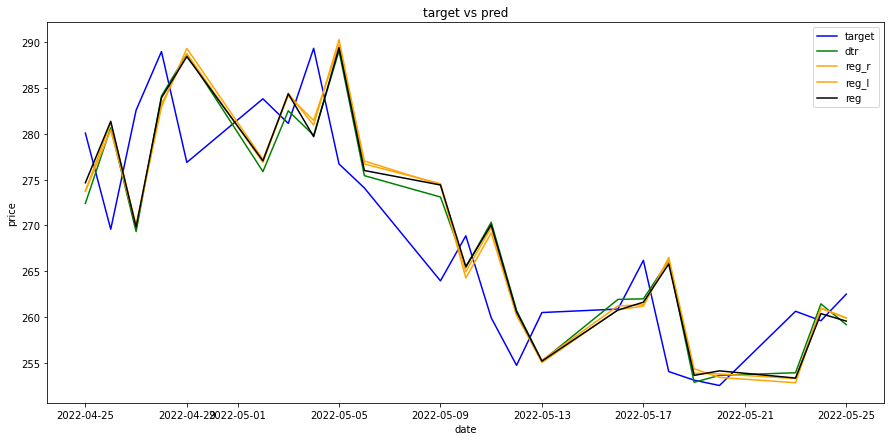

In [ ]:
plt.figure(figsize=(15, 7))
pred_reg, target_cb = pipeline('LinearRegression', tickerDf.copy(), 'Close', train=False)
pred_lgb, target_cb = pipeline('LGBMRegressor', tickerDf.copy(), 'Close')
pred_cb, target_cb = pipeline('CatBoostRegressor', tickerDf.copy(), 'Close')
pred_reg_l, target_cb = pipeline('LinearRegression_lasso', tickerDf.copy(), 'Close', train=False)
pred_reg_r, target_cb = pipeline('LinearRegression_ridge', tickerDf.copy(), 'Close', train=False)
pred_dtr, target_cb = pipeline('DecisionTreeRegressor', tickerDf.copy(), 'Close', train=False)
plt.plot(target_cb.loc['2022-04-23':'2022-05-25'], label='target', color='b')
plt.plot(pred_cb.loc['2022-04-23':'2022-05-25'], label='cb', color='red')
plt.plot(pred_lgb.loc['2022-04-23':'2022-05-25'], label='lgb', color='cyan')
plt.plot(pred_dtr.loc['2022-04-23':'2022-05-25'], label='dtr', color='green')
plt.plot(pred_reg_r.loc['2022-04-23':'2022-05-25'], label='reg_r', color='orange')
plt.plot(pred_reg_l.loc['2022-04-23':'2022-05-25'], label='reg_l', color='orange')
plt.plot(pred_reg.loc['2022-04-23':'2022-05-25'], label='reg', color='black')
plt.title('target vs pred')
plt.ylabel('price')
plt.xlabel('date')
plt.legend()
plt.show()

In [ ]:

#prediction of close
pred_reg, target_cb = pipeline('LinearRegression', tickerDf.copy(), 'Close', train=False)
pred_lgb, target_cb = pipeline('LGBMRegressor', tickerDf.copy(), 'Close')
pred_cb, target_cb = pipeline('CatBoostRegressor', tickerDf.copy(), 'Close')
pred_reg_l, target_cb = pipeline('LinearRegression_lasso', tickerDf.copy(), 'Close', train=False)
pred_reg_r, target_cb = pipeline('LinearRegression_ridge', tickerDf.copy(), 'Close', train=False)
pred, target = pipeline('RandomForestRegressor', tickerDf.copy(), 'Close')

,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



pct_change_metrics (MSE, MAE, MAPE) = (0.0002593324338873061, 0.011122976181810525, 40.65187610968234)

un_pct_change_metrics (MSE, MAE, MAPE) = (4.933060430061473, 1.113218381502218, 0.011112101914801687)


,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


0:	learn: 0.0234511	total: 4.78ms	remaining: 9.58s
1:	learn: 0.0234497	total: 9.4ms	remaining: 9.41s
2:	learn: 0.0234478	total: 14ms	remaining: 9.35s
3:	learn: 0.0234463	total: 18.5ms	remaining: 9.23s
4:	learn: 0.0234448	total: 22.8ms	remaining: 9.11s
5:	learn: 0.0234433	total: 27.7ms	remaining: 9.22s
6:	learn: 0.0234402	total: 32ms	remaining: 9.13s
7:	learn: 0.0234376	total: 36.7ms	remaining: 9.15s
8:	learn: 0.0234353	total: 41.3ms	remaining: 9.17s
9:	learn: 0.0234331	total: 46ms	remaining: 9.18s
10:	learn: 0.0234308	total: 50.5ms	remaining: 9.16s
11:	learn: 0.0234286	total: 55.1ms	remaining: 9.16s
12:	learn: 0.0234274	total: 59.6ms	remaining: 9.13s
13:	learn: 0.0234258	total: 63.9ms	remaining: 9.09s
14:	learn: 0.0234243	total: 68.6ms	remaining: 9.1s
15:	learn: 0.0234227	total: 73.5ms	remaining: 9.14s
16:	learn: 0.0234215	total: 78.4ms	remaining: 9.17s
17:	learn: 0.0234198	total: 83.3ms	remaining: 9.2s
18:	learn: 0.0234166	total: 87.9ms	remaining: 9.19s
19:	learn: 0.0234148	total: 92.

,Open,High,Low,Close,Open_pct_change,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,shift_Open_pct_change_10
Date,,,,,,,,,,,,,,,
1986-03-31,0.060564,0.060564,0.058927,0.060018,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713,0.098033
1986-04-01,0.060018,0.060018,0.059473,0.059473,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250,0.035713
1986-04-02,0.059473,0.061109,0.059473,0.060018,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432,0.017250
1986-04-03,0.060564,0.062201,0.060564,0.060564,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390,-0.025432
1986-04-04,0.060564,0.061109,0.060564,0.060564,0.000000,0.018347,-0.009090,-0.009009,0.018348,0.028300,0.019229,-0.028035,-0.027271,-0.026547,-0.017390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,257.239990,258.540009,246.440002,252.559998,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285,-0.037578
2022-05-23,255.490005,261.500000,253.429993,260.649994,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036,-0.017285
2022-05-24,257.890015,261.329987,253.500000,259.619995,0.009394,-0.006803,0.013155,-0.034601,-0.009385,0.023657,0.010142,-0.001319,-0.030074,-0.022121,0.006036


,High,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,...,shift_High_pct_change_1,shift_High_pct_change_2,shift_High_pct_change_3,shift_High_pct_change_4,shift_High_pct_change_5,shift_High_pct_change_6,shift_High_pct_change_7,shift_High_pct_change_8,shift_High_pct_change_9,shift_High_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-15,0.063292,0.061109,0.063292,8.771007e-03,1.785609e-02,1.818095e-02,0.009173,-0.018016,-3.044090e-07,0.000000e+00,...,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02,-9.008970e-03
1986-04-16,0.066020,0.062746,0.065475,8.695130e-03,8.771007e-03,1.785609e-02,0.018181,0.009173,-1.801638e-02,-3.044090e-07,...,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02,1.818121e-02
1986-04-17,0.066020,0.065475,0.066020,-3.612411e-08,8.695130e-03,8.771007e-03,0.017856,0.018181,9.173411e-03,-1.801638e-02,...,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02,1.785582e-02
1986-04-18,0.066020,0.063292,0.063838,3.449071e-02,-3.612411e-08,8.695130e-03,0.008771,0.017856,1.818095e-02,9.173411e-03,...,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07,-1.754280e-02
1986-04-21,0.064384,0.062201,0.063838,8.332904e-03,3.449071e-02,-3.612411e-08,0.008695,0.008771,1.785609e-02,1.818095e-02,...,1.289240e-07,8.236804e-08,4.311076e-02,-8.556251e-03,-3.886147e-07,2.632433e-02,8.849288e-03,8.927701e-03,5.260043e-07,-3.044090e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,258.540009,246.440002,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,...,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02,-2.479491e-02
2022-05-23,261.500000,253.429993,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,0.010142,-1.319361e-03,-3.007373e-02,...,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03,-2.467327e-02
2022-05-24,261.329987,253.500000,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,0.023657,1.014177e-02,-1.319361e-03,...,1.144887e-02,3.376393e-03,-2.249618e-02,-1.533947e-02,9.442410e-03,1.056872e-02,1.215951e-02,-4.230535e-02,-8.730701e-03,5.103665e-03


,Low,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,...,shift_Low_pct_change_1,shift_Low_pct_change_2,shift_Low_pct_change_3,shift_Low_pct_change_4,shift_Low_pct_change_5,shift_Low_pct_change_6,shift_Low_pct_change_7,shift_Low_pct_change_8,shift_Low_pct_change_9,shift_Low_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-30,0.068748,0.070385,7.406430e-03,0.054694,0.108229,0.004347,-0.017103,2.134468e-07,-3.305565e-02,8.332904e-03,...,-2.238717e-02,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486,0.026784
1986-05-01,0.068203,0.069294,-2.941835e-02,0.007406,0.054694,0.108229,0.004347,-1.710294e-02,2.134468e-07,-3.305565e-02,...,-3.816571e-02,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341,0.043486
1986-05-02,0.068748,0.069294,-2.272604e-02,-0.029418,0.007406,0.054694,0.108229,4.347175e-03,-1.710294e-02,2.134468e-07,...,-7.936157e-03,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240,-0.033341
1986-05-05,0.068748,0.068748,-1.550291e-02,-0.022726,-0.029418,0.007406,0.054694,1.082288e-01,4.347175e-03,-1.710294e-02,...,7.999485e-03,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772,-0.017240
1986-05-06,0.069294,0.069294,1.360367e-07,-0.015503,-0.022726,-0.029418,0.007406,5.469365e-02,1.082288e-01,4.347175e-03,...,1.360367e-07,0.007999,-0.007936,-0.038166,-0.022387,0.046873,0.113047,0.008771,-0.008695,0.008772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,246.440002,252.559998,-3.460078e-02,-0.009385,0.023657,0.010142,-0.001319,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-3.520985e-03,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307,-0.011191
2022-05-23,253.429993,260.649994,1.315477e-02,-0.034601,-0.009385,0.023657,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,-2.159760e-02,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646,-0.029307
2022-05-24,253.500000,259.619995,-6.802926e-03,0.013155,-0.034601,-0.009385,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,...,2.836386e-02,-0.021598,-0.003521,-0.034677,0.026116,0.001684,0.021318,-0.035789,-0.021768,0.006646


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


,Close,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-15,0.069839,7.812252e-03,7.873273e-03,-7.811612e-03,0.007873,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,-1.550291e-02,...,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000,-0.015503
1986-05-16,0.070385,-7.751454e-03,7.812252e-03,7.873273e-03,-0.007812,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,1.360367e-07,...,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873,0.000000
1986-05-19,0.069294,-2.418246e-07,-7.751454e-03,7.812252e-03,0.007873,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,-1.360367e-07,...,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936,-0.007873
1986-05-20,0.068748,7.811850e-03,-2.418246e-07,-7.751454e-03,0.007812,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,0.000000e+00,...,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000,0.007936
1986-05-21,0.067657,-1.550277e-02,7.811850e-03,-2.418246e-07,-0.007751,7.812252e-03,7.873273e-03,-7.811612e-03,7.873114e-03,3.994972e-07,...,-0.007873,-0.015503,0.007812,0.000000,-0.007751,0.007812,0.007874,-0.007812,0.007874,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,252.559998,-3.460078e-02,-9.385004e-03,2.365747e-02,0.010142,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,-1.728465e-02,...,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945,-0.009447
2022-05-23,260.649994,1.315477e-02,-3.460078e-02,-9.385004e-03,0.023657,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,6.035785e-03,...,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596,-0.036945
2022-05-24,259.619995,-6.802926e-03,1.315477e-02,-3.460078e-02,-0.009385,2.365747e-02,1.014177e-02,-1.319361e-03,-3.007373e-02,-2.212089e-02,...,0.032032,-0.002291,-0.003700,-0.045530,0.020344,0.001455,0.022596,-0.019958,-0.033210,0.018596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



pct_change_metrics (MSE, MAE, MAPE) = (0.00025990698372644537, 0.011038237389536057, 13.215708593426177)

un_pct_change_metrics (MSE, MAE, MAPE) = (4.987887771964614, 1.1065209203259299, 0.01102866113312634)


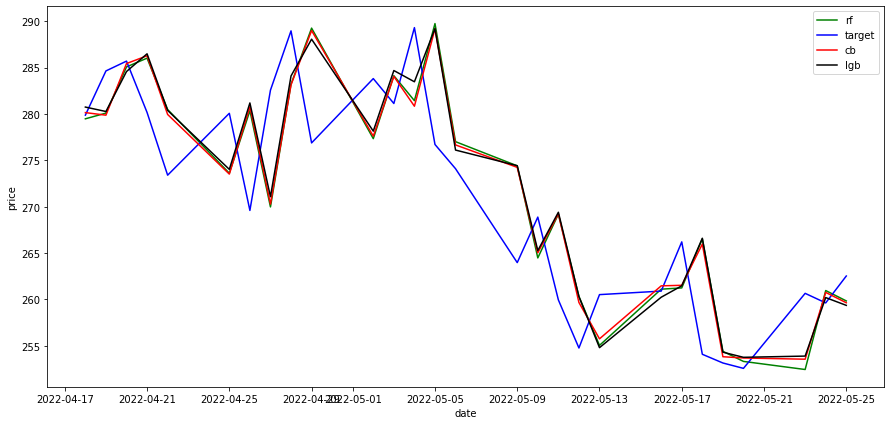

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(pred.loc['2022-04-15':'2022-05-25'], label='rf', color='green')
plt.plot(tickerDf['Close'].loc['2022-04-15':'2022-05-25'], label='target', color='b')
plt.plot(pred_cb.loc['2022-04-15':'2022-05-25'], label='cb', color='red')
plt.plot(pred_lgb.loc['2022-04-15':'2022-05-25'], label='lgb', color='black')
plt.plot(pred_dtr.loc['2022-04-25':'2022-05-25'], label='dtr', color='green')
plt.plot(pred_reg_r.loc['2022-04-23':'2022-05-25'], label='ridge', color='black')
plt.plot(pred_reg_l.loc['2022-04-23':'2022-05-25'], label='lasso', color='orange')
plt.plot(pred_reg.loc['2022-04-25':'2022-05-25'], label='reg', color='red')
plt.ylabel('price')
plt.xlabel('date')
plt.legend()
plt.show()